In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor as RFE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from sklearn import preprocessing

%matplotlib inline

In [2]:
df = pd.read_csv('rnn_data_prajwal.csv', parse_dates=['DateTime'])#, index_col='DateTime')

In [3]:
df.head()

,Unnamed: 0,Fc,DateTime,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws
0,1,3.070399,2013-01-01 01:00:00,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662
1,2,2.948313,2013-01-01 01:30:00,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636
2,3,2.369790,2013-01-01 02:00:00,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619
3,4,0.105580,2013-01-01 02:30:00,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582
4,6,2.085828,2013-01-01 03:30:00,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534


In [4]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws']
yvar = 'Fc'

### Feature synthesis

In [5]:
import featuretools as ft

In [6]:
# Make an entityset and add the entity
es = ft.EntitySet(id="NA")

# Add the entire data table as an entity
es.entity_from_dataframe(entity_id = "data",
                         dataframe = df[Xvar],
                         make_index=True,
                         index = "index")

es['data']

Entity: data
  Variables:
    index (dtype: index)
    Ta (dtype: numeric)
    Ws (dtype: numeric)
    Fg (dtype: numeric)
    VPD (dtype: numeric)
    Fn (dtype: numeric)
    q (dtype: numeric)
    Ts (dtype: numeric)
    Sws (dtype: numeric)
  Shape:
    (Rows: 9015, Columns: 9)

In [7]:
ft.list_primitives()['type'].unique()

array(['aggregation', 'transform'], dtype=object)

In [8]:
trans_primitives = ['add_numeric', 'multiply_numeric']

# To see full list of availabel primitives
t = ft.list_primitives()
t.loc[t['type']=='transform', 'name'].values
#t.loc[t['type']=='aggregation', 'name']

array(['cum_sum', 'not_equal_scalar', 'greater_than', 'latitude', 'year',
       'divide_numeric', 'and', 'equal_scalar', 'not', 'week',
       'multiply_numeric_scalar', 'less_than_equal_to_scalar',
       'modulo_numeric_scalar', 'diff', 'second',
       'scalar_subtract_numeric_feature', 'divide_by_feature',
       'less_than_scalar', 'time_since', 'day', 'cum_min',
       'subtract_numeric', 'greater_than_equal_to_scalar',
       'num_characters', 'time_since_previous', 'cum_count',
       'add_numeric', 'is_null', 'greater_than_scalar', 'longitude',
       'is_weekend', 'not_equal', 'or', 'percentile', 'month',
       'multiply_boolean', 'equal', 'modulo_by_feature', 'negate',
       'minute', 'multiply_numeric', 'less_than_equal_to',
       'modulo_numeric', 'isin', 'hour', 'cum_max',
       'subtract_numeric_scalar', 'divide_numeric_scalar', 'less_than',
       'num_words', 'cum_mean', 'add_numeric_scalar',
       'greater_than_equal_to', 'weekday', 'absolute', 'haversine'],
   

In [9]:
# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data',
                                      trans_primitives = trans_primitives)

feature_matrix.head()

,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws,Fn + Ta,Fn + Ws,...,Sws + Ts * Ta + Ws,Fg + Ws * Sws + Ts,Fg * Fg + Ws,Fn + Ts * q + Ta,Ts + VPD * VPD,Fg + Ta * Sws + Ta,Ts + Ws * Ws,Fn * q + VPD,Fg + Ws * q + VPD,Sws + Ta * VPD
index,,,,,,,,,,,,,,,,,,,,,
0,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662,-12.637188,-37.555899,...,939.953394,-611.082583,396.707616,-198.390160,39.618743,162.568214,71.493320,-47.496563,-22.653860,31.992205
1,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636,-9.349743,-33.509652,...,933.203152,-534.330099,318.774570,-105.070428,35.341945,199.915448,85.230564,-38.953419,-18.039052,28.465105
2,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619,-11.739534,-36.083844,...,899.053901,-519.764842,298.468091,-164.042264,32.875623,211.025860,65.809986,-38.692053,-16.611302,26.386834
3,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582,-16.139507,-40.328986,...,862.491967,-515.548064,291.367682,-265.430821,30.142726,203.016811,51.340199,-39.461465,-15.370443,23.902647
4,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534,-32.934593,-54.793334,...,847.187043,-589.620999,410.381763,-648.796390,25.239825,71.316621,90.813729,-46.354836,-15.287405,19.472374


In [10]:
Xvar_synth = feature_matrix.keys()
len(Xvar_synth)

666

#### Polynomial features 

In [11]:
poly = preprocessing.PolynomialFeatures(3)
new_features = poly.fit_transform(df[Xvar])
poly_features = pd.DataFrame(new_features, columns=poly.get_feature_names())
poly_features = poly_features.drop(columns=['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'])

In [12]:
full_df = pd.concat((feature_matrix, df[yvar], poly_features), axis=1)

In [13]:
full_df.shape

(9015, 823)

In [21]:
Xvar_synth = np.concatenate((poly_features.keys(), feature_matrix.keys()))
len(Xvar_synth)

822

### Feature reduction

In [ ]:
corr_matrix = feature_matrix.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

threshold = 0.8

# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d features to remove.' % (len(collinear_features)))

features_filtered = feature_matrix.drop(columns = collinear_features)
print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

In [ ]:
Xvar_reduced_features_synth = features_filtered.keys()
len(Xvar_reduced_features_synth)

In [ ]:
Xvar_reduced_features_synth

### Train/Test split

In [14]:
# split into input (X) and output (Y) variables
n_train= 8500

train_df = full_df.iloc[:n_train]
test_df =  full_df.iloc[n_train:] 

print(train_df.shape, test_df.shape)


(8500, 823) (515, 823)


### RFE with standard features

In [15]:
reg = RFE(n_estimators=500, 
          max_depth = 10, n_jobs=-1, random_state=42).fit(train_df[Xvar], train_df[yvar])
y_pred_rfe = reg.predict(test_df[Xvar])
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe)))

RMSE RF reg:  1.5746805886483042


### RFE with synthesised features

In [22]:
reg_synth = RFE(n_estimators=500, 
          max_depth = 10, n_jobs=-1, random_state=42).fit(train_df[Xvar_synth], train_df[yvar])
y_pred_rfe_synth = reg_synth.predict(test_df[Xvar_synth])
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_synth)))

RMSE RF reg:  1.5845513216692775


### Feature importance, selection and re-run of the model

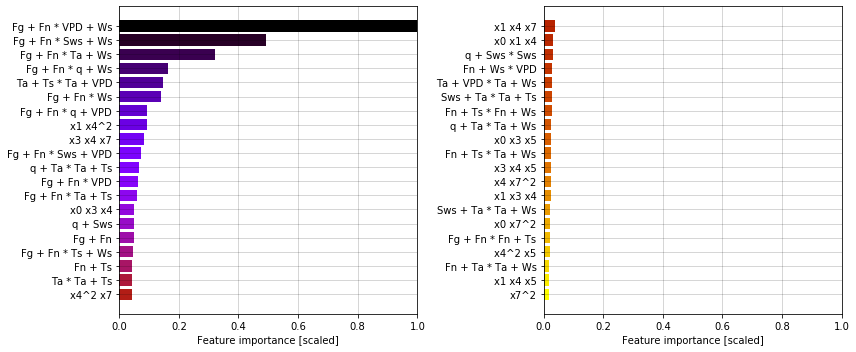

In [24]:
nfeatures = 40
feature_impo_df = pd.DataFrame({'weight':reg_synth.feature_importances_/reg_synth.feature_importances_.max(),'feature':Xvar_synth}).sort_values(by="weight", ascending=False)[:nfeatures]

cmap = cm.get_cmap(plt.get_cmap("gnuplot"))(np.linspace(0,1,nfeatures))

ncols=2
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12,5), sharex=True)

for j in range(ncols): 
    jbegin, jend = j*20, (j+1)*20
    ax[j].barh(feature_impo_df['feature'][jbegin: jend], feature_impo_df['weight'][jbegin: jend], color=cmap[jbegin:jend], zorder=0.1)
    ax[j].invert_yaxis()
    ax[j].set_xlim(0,1)
    ax[j].set_xlabel('Feature importance [scaled]')
    ax[j].grid(alpha=0.2, color='k')
plt.tight_layout()
display()

In [ ]:
#Xvar_sel_synth = list(feature_impo_df['feature'].values[i] for i in [0,4,5,6,7,8,9,10])
Xvar_sel_synth = feature_impo_df['feature'].values[0:10]

### RFE with top few synthesised features

In [ ]:
reg_sel_synth = RFE(n_estimators=500, 
          max_depth = 10, n_jobs=-1, random_state=42).fit(train_df[Xvar_sel_synth], train_df[yvar])
y_pred_rfe_sel_synth = reg_sel_synth.predict(test_df[Xvar_sel_synth])
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_sel_synth)))

In [ ]:
reg_sel_red_synth = RFE(n_estimators=500, 
          max_depth = 10, n_jobs=-1, random_state=42).fit(train_df[Xvar_reduced_features_synth], train_df[yvar])
y_pred_rfe_sel_red_synth = reg_sel_red_synth.predict(test_df[Xvar_reduced_features_synth])
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_sel_red_synth)))

### Diagnostic plot

In [ ]:
plt.plot(test_df[yvar], y_pred_rfe, '.', label='RF Reg', alpha=0.6)
plt.plot(test_df[yvar], y_pred_rfe_synth, '.', label='RF Feature Synth', alpha=0.6)
plt.plot(test_df[yvar], y_pred_rfe_sel_synth, '.', label='RF Selected Feature Synth', alpha=0.6)
plt.plot([-10,15], [-10,15], '--k')
plt.xlabel('Yobs')
plt.ylabel('Ypred')
plt.legend()
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe)))
print("RMSE RF reg synth: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_synth)))
print("RMSE RF reg sel synth: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_sel_synth)))
print("RMSE RF reg sel red synth: ", np.sqrt(mean_squared_error(test_df[yvar], y_pred_rfe_sel_red_synth)))